In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek

In [2]:
data_raw = pd.read_csv('Fraud_check.csv')
data_raw

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [3]:
data = data_raw.copy()
x = 0
for i in data_raw['Taxable.Income']:
    if i <= 30000:
        data['Taxable.Income'][x] = 'Risky'
    else:
        data['Taxable.Income'][x] = 'Good'
    x += 1
data

<ipython-input-3-1f92bf44be96>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Taxable.Income'][x] = 'Good'
C:\Users\kp305\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-3-1f92bf44be96>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Taxable.Income'][x] = 'Risky'


,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,Good,50047,10,YES
1,YES,Divorced,Good,134075,18,YES
2,NO,Married,Good,160205,30,YES
3,YES,Single,Good,193264,15,YES
4,NO,Married,Good,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,Good,39492,7,YES
596,YES,Divorced,Good,55369,2,YES
597,NO,Divorced,Good,154058,0,YES
598,YES,Married,Good,180083,17,NO


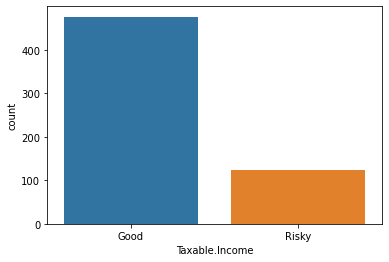

In [4]:
sns.countplot(data['Taxable.Income'])

In [5]:
y = data['Taxable.Income']
X = data.drop('Taxable.Income', axis = 1)
X['Undergrad'] = X['Undergrad'].map({'NO' : 0, 'YES' : 1})
X['Marital.Status'] = X['Marital.Status'].map({'Single' : 0, 'Married' : 1, 'Divorced' : 2})
X['Urban'] = X['Urban'].map({'NO' : 0, 'YES' : 1})
X

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban
0,0,0,50047,10,1
1,1,2,134075,18,1
2,0,1,160205,30,1
3,1,0,193264,15,1
4,0,1,27533,28,0
...,...,...,...,...,...
595,1,2,39492,7,1
596,1,2,55369,2,1
597,0,2,154058,0,1
598,1,1,180083,17,0


### Resampling the data

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [7]:
kfold = KFold(10)
accuracy = []
for i in range(1,10):
    forest = RandomForestClassifier(n_estimators = i)
    results = cross_val_score(forest, X, y, cv = kfold)
    accuracy.append(np.mean(results))
accuracy

[0.6616666666666667,
 0.74,
 0.685,
 0.7466666666666666,
 0.7283333333333334,
 0.7266666666666666,
 0.7166666666666667,
 0.7433333333333334,
 0.725]

In [8]:
n_est_ideal = accuracy.index(max(accuracy[2:]))
n_est_ideal

3

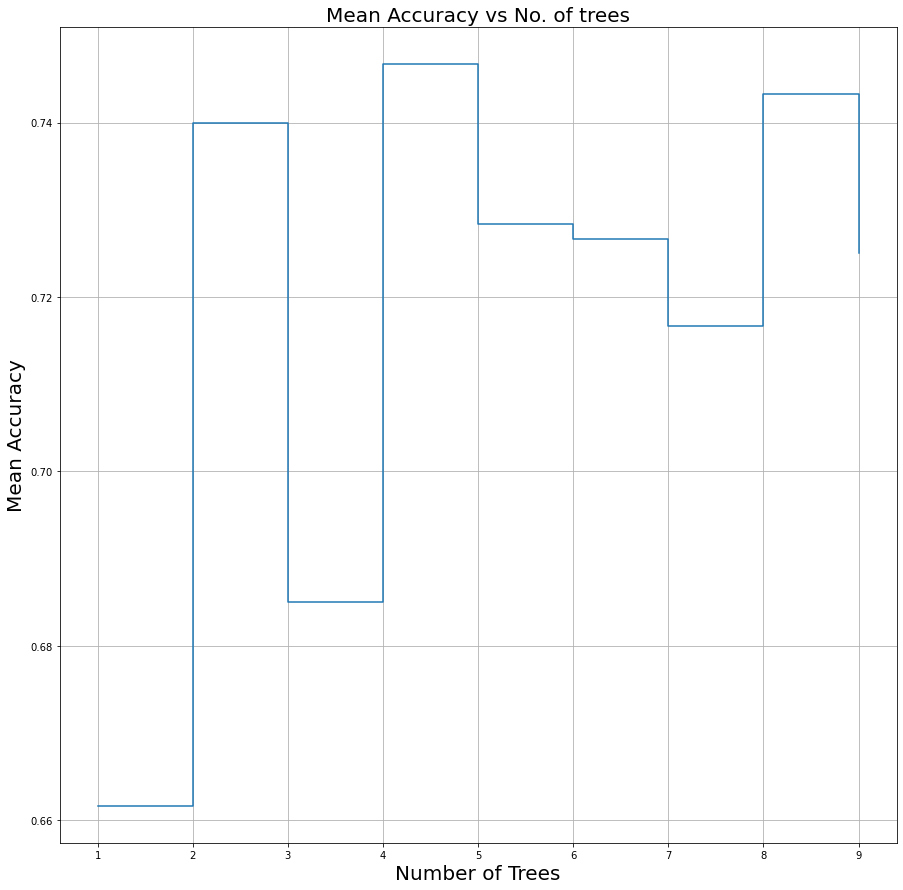

In [9]:
plt.figure(figsize = (15,15))
plt.plot(range(1,10), accuracy, drawstyle = 'steps-post')
plt.xlabel('Number of Trees', fontsize = 20)
plt.ylabel('Mean Accuracy', fontsize = 20)
plt.title('Mean Accuracy vs No. of trees', fontsize = 20)
plt.grid()

In [10]:
resample = SMOTETomek(random_state = 42)
X_res, y_res = resample.fit_resample(X, y)
(X_res.shape, y_res.shape)

((730, 5), (730,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)


In [12]:
forest = RandomForestClassifier(random_state = 42, n_estimators = n_est_ideal)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [13]:
predictions = forest.predict(X_test)
np.mean(predictions == y_test)

0.7083333333333334

In [14]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Good       0.79      0.85      0.82        94
       Risky       0.26      0.19      0.22        26

    accuracy                           0.71       120
   macro avg       0.53      0.52      0.52       120
weighted avg       0.68      0.71      0.69       120



In [15]:
cf_mat = confusion_matrix(y_test, predictions)
cf_mat

array([[80, 14],
       [21,  5]], dtype=int64)

C:\Users\kp305\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


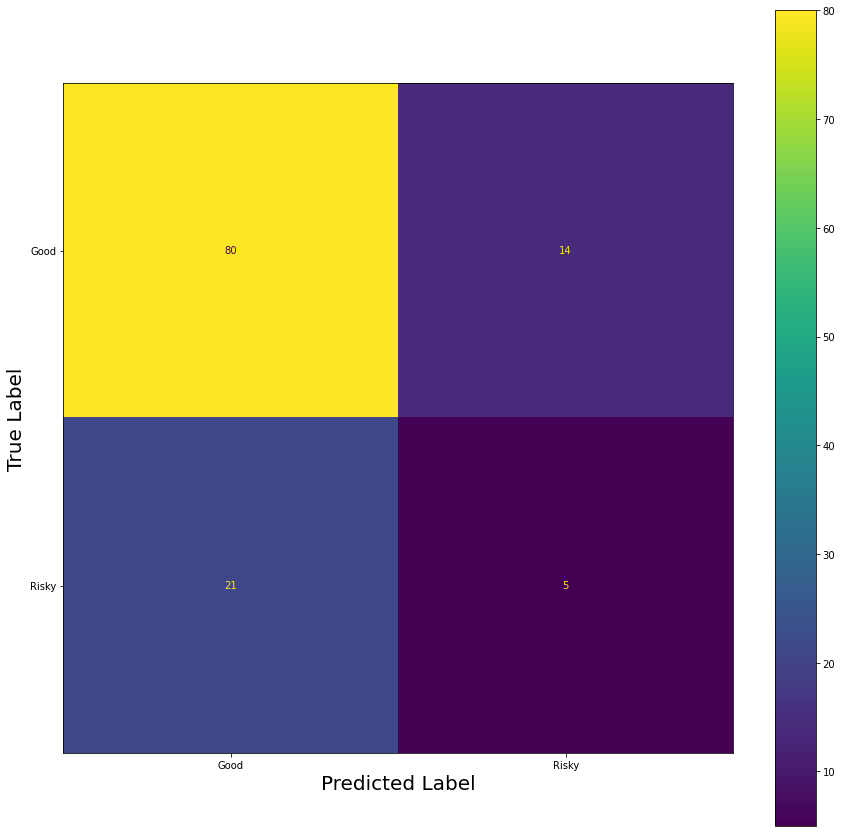

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
plot_confusion_matrix(forest, X_test, y_test, ax = ax)
ax.set_xlabel('Predicted Label', fontsize = 20)
ax.set_ylabel('True Label', fontsize = 20)
plt.show()